In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd

from os import listdir
from os.path import isfile, join

import shutil

import seaborn as sns

from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
df = pd.read_csv('data/HAM10000_metadata.csv')
df.head()

filtered = df.iloc[list(range(0, len(df), 2)),:].copy().reset_index(drop = True)
filtered.head()

filtered['dx'].value_counts(normalize = True)

label_encoding = sorted(list(filtered['dx'].unique()))
label_encoding

#############Enablefor mving files #################

# image_labels = dict(zip(filtered['image_id'], filtered['dx']))

# train_path = 'data/all_images'
# onlyfiles = [f for f in listdir(train_path) if isfile(join(train_path, f))]

# for i in filtered['image_id']:
#     source = train_path + "/" + i + '.jpg'
#     dest = train_path + "/" + image_labels[i] + "/" + i + '.jpg'
# #     print(source)
# #     print(dest)
#     shutil.copy(source, dest)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [3]:
# Load training and validation sets

# prefetches images
# keep the images for training ready. 
# when one batch is being used for training

ds_train_ = image_dataset_from_directory(
    'data/all_images',
    labels='inferred',
    label_mode='categorical',
    image_size=[600, 450],
    interpolation='nearest',
    batch_size=32,
    shuffle=True,
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'training',
    seed = 2
)
ds_valid_ = image_dataset_from_directory(
    'data/all_images',
    labels='inferred',
    label_mode='categorical',
    image_size=[600, 450],
    interpolation='nearest',
    batch_size=32,
    shuffle=True,
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'validation',
    seed = 2
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5008 files belonging to 7 classes.
Using 4007 files for training.
Found 5008 files belonging to 7 classes.
Using 1001 files for validation.


# Data Augmentation (To be explored later)

In [4]:
# all of the "factor" parameters indicate a percent-change
augment = keras.Sequential([
    # preprocessing.RandomContrast(factor=0.5),
    preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    # preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    # preprocessing.RandomWidth(factor=0.15), # horizontal stretch
    # preprocessing.RandomRotation(factor=0.20),
    # preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
])

# NN

## NN creation

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    #input image
    layers.InputLayer(input_shape=[600, 450, 3]),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),
    
     # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=16, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),
    
    # Block four
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=8, kernel_size=3, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Flattening back to "1D"
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(32, activation=layers.LeakyReLU(alpha=0.01)),
    
    #output
    layers.Dense(7, activation='softmax'),
])

optimizer = tf.keras.optimizers.Adam(epsilon = 0.01)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 600, 450, 3)      21        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 596, 446, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 298, 223, 32)     0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 298, 223, 32)     224       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 294, 219, 32)      25632     
                                                      

In [6]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=1,
    use_multiprocessing=True,
)

126/126 [==============================] - 1061s 8s/step - loss: 1.2640 - categorical_accuracy: 0.6526 - val_loss: 1.1781 - val_categorical_accuracy: 0.6364


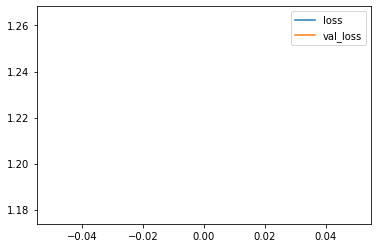

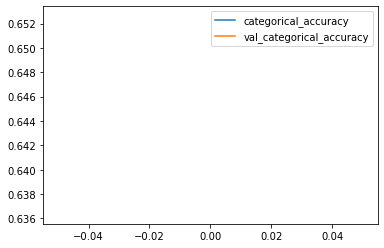

In [7]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();

In [8]:
predictions = np.array([])
labels =  np.array([])
for x, y in ds_valid:
    predict_x=model.predict(x) 
    classes_x=np.argmax(predict_x,axis=1)
    predictions = np.concatenate([predictions, classes_x])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

confusion_matrix(y_true=labels, y_pred=predictions)

array([[   1,    0,    4,    0,   12,  110,    0],
       [   1,    0,    6,    0,   13,  185,    3],
       [   0,    0,   46,    1,  102,  290,    8],
       [   0,    0,    1,    0,    5,   38,    1],
       [   1,    0,   15,    1,  122,  300,    3],
       [   0,    1,   33,    1,  160, 2472,   16],
       [   0,    1,    0,    0,    3,   47,    4]], dtype=int64)

<AxesSubplot:>

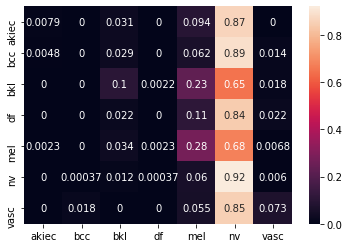

In [9]:
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predictions, normalize = 'true'),
             columns = label_encoding,
             index = label_encoding,)
sns.heatmap(df, annot = True)

In [10]:
model2 = keras.Sequential([
    layers.InputLayer(input_shape=[600, 450, 3]),
    
    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=16, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),
    
    # Block four
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=8, kernel_size=3, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(32, activation=layers.LeakyReLU(alpha=0.01)),
    layers.Dense(7, activation='softmax'),
])

optimizer = tf.keras.optimizers.Adam(epsilon = 0.01)
model2.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_5 (Batc  (None, 600, 450, 3)      21        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 596, 446, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 298, 223, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 298, 223, 32)     224       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 294, 219, 32)      25632     
                                                      

In [11]:
class_weights = {
    0 : 1,
    1 : 1,
    2 : 1,
    3 : 1,
    4 : 5,
    5 : 1,
    6 : 1,
}

In [12]:
history = model2.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=1,
    use_multiprocessing=True,
    class_weight = class_weights
)

126/126 [==============================] - 1063s 8s/step - loss: 2.0670 - categorical_accuracy: 0.5393 - val_loss: 1.3643 - val_categorical_accuracy: 0.4905


In [13]:
predictions = np.array([])
labels =  np.array([])
for x, y in ds_train:
    predict_x=model2.predict(x) 
    classes_x=np.argmax(predict_x,axis=1)
    predictions = np.concatenate([predictions, classes_x])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

confusion_matrix(y_true=labels, y_pred=predictions)

array([[   1,   21,   11,    1,   76,   17,    0],
       [   0,   64,   18,    0,  101,   25,    0],
       [   2,   21,   47,    0,  339,   38,    0],
       [   0,    9,    6,    0,   19,   11,    0],
       [   0,    1,    6,    0,  405,   30,    0],
       [   3,   31,   27,    4, 1091, 1527,    0],
       [   0,    5,    2,    0,   18,   30,    0]], dtype=int64)

<AxesSubplot:>

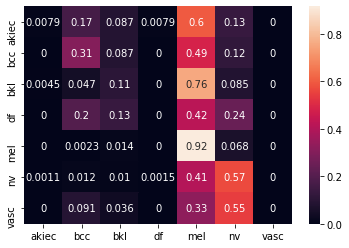

In [14]:
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predictions, normalize = 'true'),
             columns = label_encoding,
             index = label_encoding,)
sns.heatmap(df, annot = True)

# binary classification

In [15]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'data/binary_class',
    labels='inferred',
    label_mode='binary',
    image_size=[600, 450],
    interpolation='nearest',
    batch_size=32,
    shuffle=True,
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'training',
    seed = 1
)
ds_valid_ = image_dataset_from_directory(
    'data/binary_class',
    labels='inferred',
    label_mode='binary',
    image_size=[600, 450],
    interpolation='nearest',
    batch_size=32,
    shuffle=True,
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'validation',
    seed = 1
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5008 files belonging to 2 classes.
Using 4007 files for training.
Found 5008 files belonging to 2 classes.
Using 1001 files for validation.


In [17]:
model3 = keras.Sequential([
    layers.InputLayer(input_shape=[600, 450, 3]),
    
    # Block One
    # 
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=16, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),
    
    # Block four
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=8, kernel_size=3, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(32, activation=layers.LeakyReLU(alpha=0.01)),
    
    # output
    layers.Dense(1, activation='sigmoid'),
])

optimizer = tf.keras.optimizers.Adam(epsilon = 0.01)
model3.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_10 (Bat  (None, 600, 450, 3)      21        
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 596, 446, 32)      2432      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 298, 223, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_11 (Bat  (None, 298, 223, 32)     224       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 294, 219, 32)      25632     
                                                      

In [18]:
class_weights = {
    0 : 1,
    1 : 7
}

In [19]:
history = model3.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=2,
    use_multiprocessing=True,
    class_weight = class_weights
)

Epoch 1/2
126/126 [==============================] - 1105s 9s/step - loss: 1.1791 - accuracy: 0.6661 - val_loss: 0.5031 - val_accuracy: 0.7363
Epoch 2/2
126/126 [==============================] - 1082s 9s/step - loss: 1.2338 - accuracy: 0.6459 - val_loss: 0.5679 - val_accuracy: 0.6583


In [20]:
predictions = []
labels =  []
for x, y in ds_train:
    predictions = predictions + model3.predict(x).tolist()
    labels = labels + y.numpy().tolist()

In [21]:
predictions = [x[0] for x in predictions]
labels = [x[0] for x in labels]

In [22]:
temp = pd.DataFrame({
    'prob' : predictions,
    'label':labels
})

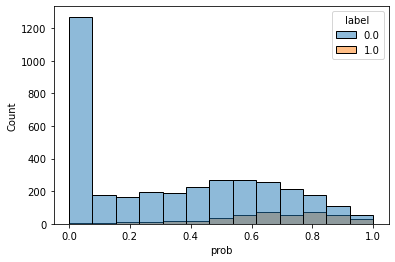

In [23]:
sns.histplot(data = temp, x = 'prob', hue = 'label')
plt.show()

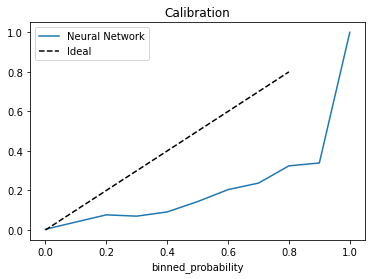

In [24]:
nbins = 10
bins = list(range(0, 100, int(100 / nbins)))
bins = [b/100 for b in bins]

def create_bins(p):
    for i in range(nbins):
        if i == nbins - 1:
            if (p > bins[i]) and (p < 1):
                return bins[i]
            else:
                return 1
        if (p > bins[i]) and (p < bins[i+1]):
            return bins[i]
    return 0

temp['binned_probability'] = temp['prob'].apply(create_bins)
temp.groupby('binned_probability')['label'].mean().plot(label = 'Neural Network')
plt.plot([0, 0.8] , [0, 0.8], 'k--',label = 'Ideal')
plt.title("Calibration")
plt.legend()
plt.show()

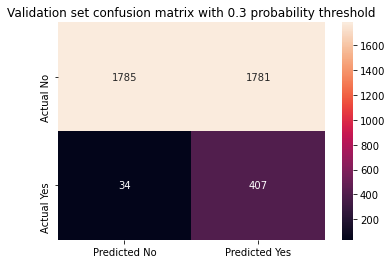

In [30]:
predicted_class = [1 if p > 0.3 else 0 for p in predictions]
confusion_matrix(y_true=labels, y_pred=predicted_class)
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predicted_class),
             columns = ['Predicted No', 'Predicted Yes'],
             index = ['Actual No', 'Actual Yes'],)
sns.heatmap(df, annot = True, fmt = 'd')
plt.title("Validation set confusion matrix with 0.3 probability threshold")
plt.show()

In [33]:
model4 = keras.Sequential([
    layers.InputLayer(input_shape=[600, 450, 3]),
    
    # Block One
    # layers.BatchNormalization(renorm=True),
#     layers.Rescaling(scale = 1./255),
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=9, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=7, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=16, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),
    
    # Block Four
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=16, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),
    
    # Block four
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=8, kernel_size=3, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(32, activation=layers.LeakyReLU(alpha=0.01)),
    
    # output
    layers.Dense(1, activation='sigmoid'),
])

optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model4.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_21 (Bat  (None, 600, 450, 3)      21        
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 592, 442, 32)      7808      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 296, 221, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_22 (Bat  (None, 296, 221, 32)     224       
 chNormalization)                                                
                                                                 
 conv2d_18 (Conv2D)          (None, 290, 215, 32)      50208     
                                                      

In [34]:
history = model4.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=1,
    use_multiprocessing=True,
    class_weight = {0:1, 1:7}
)

126/126 [==============================] - 1804s 14s/step - loss: 1.3471 - accuracy: 0.7023 - val_loss: 0.6207 - val_accuracy: 0.5934


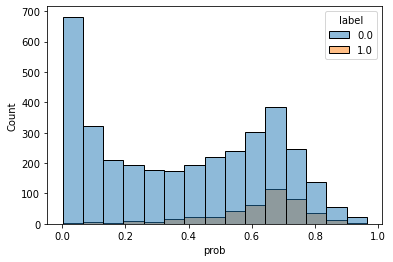

In [43]:
predictions = []
labels =  []
for x, y in ds_train:
    predictions = predictions + model4.predict(x).tolist()
    labels = labels + y.numpy().tolist()
    
predictions = [x[0] for x in predictions]
labels = [x[0] for x in labels]

temp = pd.DataFrame({
    'prob' : predictions,
    'label':labels
})

sns.histplot(data = temp, x = 'prob', hue = 'label')
plt.show()

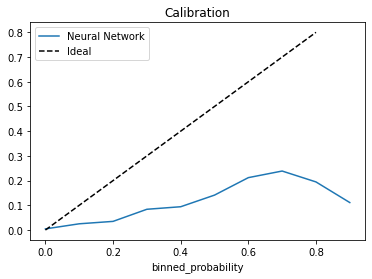

In [44]:
nbins = 10
bins = list(range(0, 100, int(100 / nbins)))
bins = [b/100 for b in bins]

def create_bins(p):
    for i in range(nbins):
        if i == nbins - 1:
            if (p > bins[i]) and (p < 1):
                return bins[i]
            else:
                return 1
        if (p > bins[i]) and (p < bins[i+1]):
            return bins[i]
    return 0

temp['binned_probability'] = temp['prob'].apply(create_bins)
temp.groupby('binned_probability')['label'].mean().plot(label = 'Neural Network')
plt.plot([0, 0.8] , [0, 0.8], 'k--',label = 'Ideal')
plt.title("Calibration")
plt.legend()
plt.show()

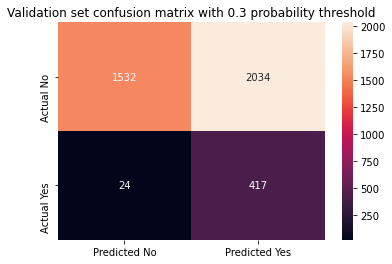

In [46]:
predicted_class = [1 if p > 0.3 else 0 for p in predictions]
confusion_matrix(y_true=labels, y_pred=predicted_class)
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predicted_class),
             columns = ['Predicted No', 'Predicted Yes'],
             index = ['Actual No', 'Actual Yes'],)
sns.heatmap(df, annot = True, fmt = 'd')
plt.title("Validation set confusion matrix with 0.3 probability threshold")
plt.show()

# NN visualisation to better understand NN built and how we can imrpove it

In [ ]:
layer_names = [layer.name for layer in model.layers]
layer_names

In [ ]:
model.layers

In [ ]:
feature_map_model = tf.keras.Model(model.inputs, layer_outputs)

In [ ]:
image_path= r"C:\Users\singl\studies\AML\Project\HAM10000Classification\data\all_images\ISIC_0024306.jpg" 
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(600, 450, 3))  
input = tf.keras.preprocessing.image.img_to_array(img)                        
# input = input.reshape((1,) + input.shape)                   
# input /= 255.0

In [ ]:
input.shape

In [ ]:
feature_maps = feature_map_model.predict(ds_valid)

In [ ]:
for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name, filters.shape)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt

#Visualizes convolutional layer activations
def visualize_activations(model, validation_iterator):

  #A keras model that will output our previous model's activations for each convolutional layer:
  activation_extractor = tf.keras.Model(inputs=model.inputs, 
                                        outputs=[layer.output for layer in model.layers if "conv2d" in layer.name])

  #Take matplotlib frame and remove axes.
  def clean_plot(plot):
    plot.axes.get_xaxis().set_visible(False)
    plot.axes.get_yaxis().set_visible(False)

  #Dict mapping from class numbers to string labels:
  class_names = {0:"Regular",1:"Ringed",2:"Merger",3:"Other"}

  #Loads a sample batch of data
  sample_batch_input,sample_labels = validation_iterator.take(1)
 
  #Grabs the first five images
  sample_batch_input = sample_batch_input[:5]
  sample_labels = sample_labels[:5]

  #Makes predictions using model.predict(x)
  sample_predictions = model.predict(sample_batch_input)

  #Iterate of images, predictions, and true labels
  for i,(image, prediction, label) in enumerate(zip(sample_batch_input, sample_predictions, sample_labels)):

    image_name = "Galaxy_{}".format(i)

    #Gets predicted class with highest probability

    predicted_class = tf.argmax(prediction).numpy()

    #Gets correct label
    actual_class = tf.argmax(label).numpy()

    print(image_name)
    print("\tModel prediction: {}".format(prediction))
    print("\tTrue label: {} ({})".format(class_names[actual_class], actual_class))
    print("\tCorrect:", predicted_class == actual_class)

    #Saves image file using matplotlib
    sample_image = image
    clean_plot(plt.imshow(sample_image))

    plt.title(image_name+" Predicted: {}, Actual: {}".format(class_names[predicted_class], class_names[actual_class]))
    plt.savefig('static/images/'+image_name+".png")
    model_layer_output = activation_extractor(tf.expand_dims(sample_image,0))
    
    plt.clf()

    #Iterates over each layer output
    for l_num,output_data in enumerate(model_layer_output):

      #Creates a subplot for each filter
      fig, axs = plt.subplots(1, output_data.shape[-1])
      
      #For each filter
      for i in range(output_data.shape[-1]):

        #Plots the filter's activations
        
        clean_plot(axs[i].imshow(output_data[0][:, :, i], cmap="gray"))
      plt.suptitle(image_name+" Conv {}".format(l_num),y=0.6)
      plt.savefig('static/images/' + image_name+ "Conv{}.png".format(l_num))
      plt.clf()

In [ ]:
visualize_activations(model,ds_train)

In [ ]:
for images, label in ds_train